# FINM3422 Coding Project 2: OTC Derivatives Pricing & Hedging

This notebook implements an object-oriented solution to value four OTC derivative trades and calculate portfolio-level hedging parameters. All data and valuations including spot prices, volatilities and time to maturity is based on market data as of May 16. Each derivative is modelled using an appropriate valuation method (e.g. Black-Scholes) to reflect key financial principles. The project's requirements are met by combining Object Oriented programming with realistic market integration to achieve accurate pricing and risk assessment in a way that resembles real world trading and risk management practices.

## Imports and Setup

In [1]:
from Option_Classes import EuropeanOption
from Option_Classes import AmericanPutOption
from Option_Classes import UpAndInCallOption
from Option_Classes import BasketCallOption
from Hedging_Parameters import HedgingCalculator
from market_data import get_close_price
from market_data import get_volatility
from market_data import get_correlation_matrix
from market_data import get_all_market_data
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import importlib
from simple_discount_curve import get_discount_rate
from simple_discount_curve import get_discount_factor
from visualise_new import plot_spot_vol_sensitivity, plot_spot_vol_sensitivity_barrier, plot_spot_vol_sensitivity_basket_bs # update
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

## Market Data Inputs

In [2]:
tickers = ["BHP.AX", "CBA.AX", "WES.AX", "CSL.AX", "WDS.AX", "MQG.AX"]
market_data = get_all_market_data(tickers, date="2025-05-16", window=60)

spot = market_data["spot"]
vol = market_data["vol"]
corr = market_data["corr"]

## broken asf atm

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


TypeError: get_volatility() got multiple values for argument 'end_date'

## Discount Curve Construction

do we build discount curve in the .ipynb file, or can we just produce the discount rates in the .py file? fix with the new discount curve file

In [3]:

# This module builds a discount curve from bank bills and bonds, and provides functions to retrieve discount factors and zero rates
from junk.instrument_classes import Bank_bill, Bond, Portfolio
from curve_classes_and_functions import YieldCurve

# Builds bootstrapped discount curve from bank bills and bonds. 

def build_discount_curve():
    # Step 1: Create instruments. Data pulled from Bloomberg. 
    bill1 = Bank_bill(face_value=100, maturity=0.25, price=98.5)
    bill2 = Bank_bill(face_value=100, maturity=0.5, price=97.3)
    bill1.set_cash_flows()
    bill2.set_cash_flows()

    bond1 = Bond(face_value=100, maturity=1.0, coupon=0.04, frequency=4, price=99.2)
    bond2 = Bond(face_value=100, maturity=2.0, coupon=0.045, frequency=4, price=98.7)
    bond3 = Bond(face_value=100, maturity=3.0, coupon=0.05, frequency=4, price=97.0)
    bond1.set_cash_flows()
    bond2.set_cash_flows()
    bond3.set_cash_flows()

    # Step 2: Add to portfolio
    portfolio = Portfolio()
    portfolio.add_bank_bill(bill1)
    portfolio.add_bank_bill(bill2)
    portfolio.add_bond(bond1)
    portfolio.add_bond(bond2)
    portfolio.add_bond(bond3)
    portfolio.set_cash_flows()

    # Step 3: Bootstrap yield curve
    yc = YieldCurve()
    yc.set_constituent_portfolio(portfolio)
    yc.bootstrap()

    return yc

# Retrieves the discount factor for a given maturity from the bootstrapped yield curve
def get_discount_factor(yield_curve, maturity):
    return yield_curve.get_discount_factor(maturity)

# Returns the interpolated zero rate for a given maturity from the yield curve
def get_zero_rate(yield_curve, maturity):
    return yield_curve.get_zero_rate(maturity)


## Trade 1: BHP European Call

The below trade is a long European call option on BHP Group Ltd (BHP) which is struck at 38.93 and expiring on the 15th September 2027. This option is valued using the Black-Scholes model based on market conditions as of 16th May 2025 including a BHP spot price of $39.72, implied volatility of 29.67% and a risk free interest rate of 5.59%. Thus, this trade positions the buyer with leveraged upside exposure to BHP  with limited downside risk

### Market Data

In [4]:
# Extract relevant data for option pricing and hedging
ticker_bhp = "BHP.AX"
date = "2025-05-16"

spot_bhp = get_close_price(ticker_bhp, date) #good
vol_bhp = get_volatility(ticker_bhp, end_date=date, window=60) #good
strike_bhp = 0.98 * spot_bhp

def time_to_expiry(start, end):
    return (end - start).days / 365.0

expiry_bhp = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years



print(f"Spot Price: {spot_bhp}, Volatility: {vol_bhp}, Strike Price: {strike_bhp}, Expiry: {expiry_bhp} years")


## remove the extra shit and make scalars, also build so that it extracts only the correlation matrix?

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Spot Price: 39.720001220703125, Volatility: 0.29673778004012413, Strike Price: 38.925601196289065, Expiry: 2.334246575342466 years


### Discount Rate

In [5]:
# Given the time to expiry, find the discount factor and zero rate
rate_bhp = get_discount_rate(expiry_bhp)  # good
print(rate_bhp)


0.05592461897265064


### Valuation

In [6]:
# Instantiate and price the option 
dividend_yield_bhp = 0.04329 
bhp_option = EuropeanOption(ticker=ticker_bhp, spot=spot_bhp, strike=strike_bhp, expiry=expiry_bhp, rate=rate_bhp, vol=vol_bhp, option_type="call", dividend_yield=dividend_yield_bhp)

print(f"Option Price: {bhp_option.price()}")

Option Price: 7.189605435663736


### Visualisation

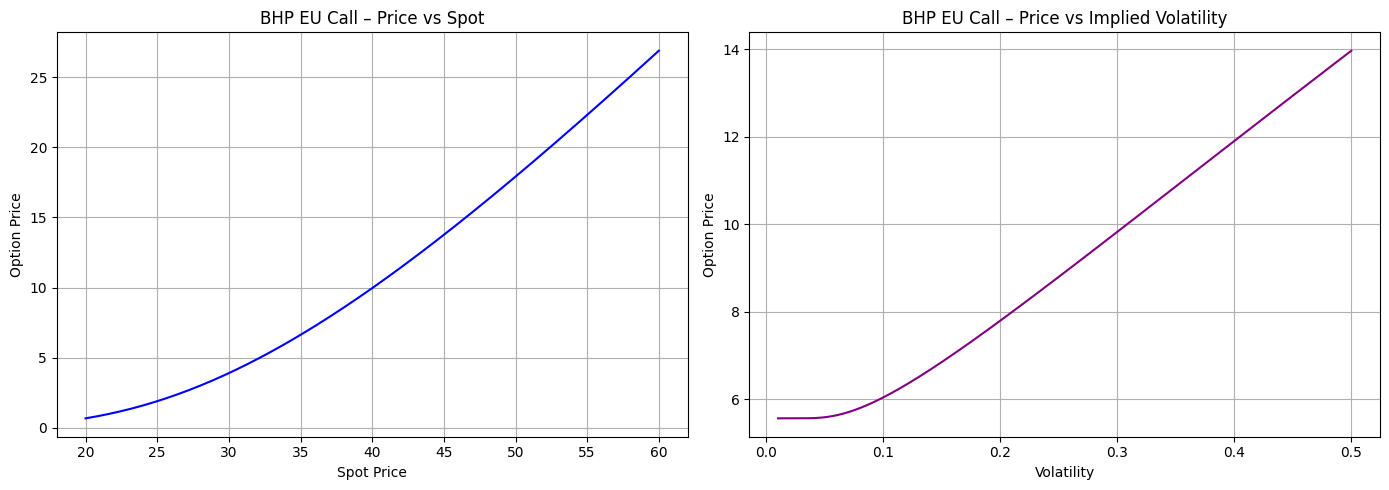

In [8]:
from visualise_new import plot_spot_vol_sensitivity

plot_spot_vol_sensitivity(option_class=EuropeanOption, label = "BHP EU Call", base_spot=spot_bhp, base_vol=vol_bhp, spot_range=(20,60,200), vol_range=(0.01,0.5,200), ticker=ticker_bhp, strike=strike_bhp, expiry=expiry_bhp, rate=rate_bhp, option_type="call")


### Hedging Parameters

In [9]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho

hc = HedgingCalculator()
greeks_bhp = hc.get_all_greeks(bhp_option, method="fd")

print("Greeks for BHP Option:")
for greek, value in greeks_bhp.items():
    print(f"{greek}: {value}")





Greeks for BHP Option:
delta: 0.5709645673965369
gamma: 0.018923920741542588
vega: 20.679600143531385
theta: 1.1997730399179076
rho: 36.15539752838792


### Hedging Strategy

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Near-the-money option
strike_bhp_ntmo = spot_bhp
expiry_bhp_ntmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years
rate_bhp_ntmo = get_discount_rate(expiry_bhp_ntmo)
bhp_option_ntmo = EuropeanOption(ticker=ticker_bhp, spot=spot_bhp, strike=strike_bhp_ntmo, expiry=expiry_bhp_ntmo, rate=rate_bhp_ntmo, vol=vol_bhp, option_type="call", dividend_yield=dividend_yield_bhp)

delta_ntmo = hc.calculate_delta_fd(bhp_option_ntmo)
gamma_ntmo = hc.calculate_gamma_fd(bhp_option_ntmo)
vega_ntmo = hc.calculate_vega_fd(bhp_option_ntmo)
rho_ntmo = hc.calculate_rho_fd(bhp_option_ntmo)

# Out-the-money option
strike_bhp_otmo = 0.9 * spot_bhp
expiry_bhp_otmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years
rate_bhp_otmo = get_discount_rate(expiry_bhp_otmo)
bhp_option_otmo = EuropeanOption(ticker=ticker_bhp, spot=spot_bhp, strike=strike_bhp_otmo, expiry=expiry_bhp_otmo, rate=rate_bhp_otmo, vol=vol_bhp, option_type="call", dividend_yield=dividend_yield_bhp)

delta_otmo = hc.calculate_delta_fd(bhp_option_otmo)
gamma_otmo = hc.calculate_gamma_fd(bhp_option_otmo)
vega_otmo = hc.calculate_vega_fd(bhp_option_otmo)
rho_otmo = hc.calculate_rho_fd(bhp_option_otmo)

hedges = {
    "Underlying Stock": {"Delta": 1, "Gamma": 0, "Vega": 0, "Rho": 0},
    "Near-the-Money Option": {"Delta": delta_ntmo, "Gamma": gamma_ntmo, "Vega": vega_ntmo, "Rho": rho_ntmo},
    "Out-the-Money Option": {"Delta": delta_otmo, "Gamma": gamma_otmo, "Vega": vega_otmo, "Rho": rho_otmo},
}

# Create a hedge matrix
hedge_matrix = pd.DataFrame(hedges).T

print("Hedge Matrix:")
print(hedge_matrix)

# Calculate the current Greeks of the BHP option
delta = hc.calculate_delta_fd(bhp_option)
gamma = hc.calculate_gamma_fd(bhp_option)
vega = hc.calculate_vega_fd(bhp_option)
rho = hc.calculate_rho_fd(bhp_option)

# Define the current Greeks of the BHP option
bhp_greeks = np.array([
    hc.calculate_delta_fd(bhp_option),
    hc.calculate_gamma_fd(bhp_option),
    hc.calculate_vega_fd(bhp_option),
    hc.calculate_rho_fd(bhp_option)
])

# Define the optimization function
def objective(weights):
    hedge_effect = hedge_matrix.values.T @ weights
    return np.linalg.norm(hedge_effect + bhp_greeks)  # Minimize the difference

# Initial guess (equal weights)
initial_weights = np.ones(len(hedge_matrix)) / len(hedge_matrix)

# Solve for optimal hedge weights
result = minimize(objective, initial_weights)

# Display results
optimal_weights = result.x
hedge_allocations = pd.DataFrame({"Instrument": hedge_matrix.index, "Optimal Weight": optimal_weights})
print("\nOptimal Hedge Allocations:")
print(hedge_allocations.round(4))

# Visualize the new greeks after hedging
minimized_greeks = hedge_matrix.values.T @ optimal_weights + bhp_greeks

greek_names = ["Delta", "Gamma", "Vega", "Rho"]
greek_matrix = pd.DataFrame({
    "Original BHP Option": bhp_greeks,
    "Post-Hedging (Minimized)": minimized_greeks
}, index=greek_names)

print("\nGreek Neutralization Result:")
print(greek_matrix.round(4))

KeyboardInterrupt: 

### Design and Model Justification

## Trade 2: CBA American Put

description of the trade

### Market Data

In [10]:
ticker_cba = "CBA.AX"
date = "2025-05-16"

spot_cba = get_close_price(ticker_cba, date) #good
vol_cba = get_volatility(ticker_cba, end_date=date, window=60) #good
strike_cba = 170.00

def time_to_expiry(start, end):
    return (end - start).days / 365.0

expiry_cba = time_to_expiry(datetime(2025, 5, 16), datetime(2026, 5, 15)) # 1 Year


print(f"Spot Price: {spot_cba}, Volatility: {vol_cba}, Strike Price: {strike_cba}, Expiry: {expiry_cba} years")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Spot Price: 169.66000366210938, Volatility: 0.26622126099171345, Strike Price: 170.0, Expiry: 0.9972602739726028 years


### Discount Rate

In [11]:
# Instantiate and price the option
rate_cba = get_discount_rate(expiry_cba)  # good
print(f"Rate for CBA Option: {rate_cba}")

Rate for CBA Option: 0.04920549734846802


### Valuation

In [12]:
# Instantiate and price the option 
dividend_yield_cba = 0.02867  
cba_option = AmericanPutOption(ticker=ticker_cba, spot=spot_cba, strike=strike_cba, expiry=expiry_cba, rate=rate_cba, vol=vol_cba, option_type="put", steps=10, dividend_yield=dividend_yield_cba)
print(f"Option Price: {cba_option.price()}")

Option Price: 16.020531072022294


### Visualisation

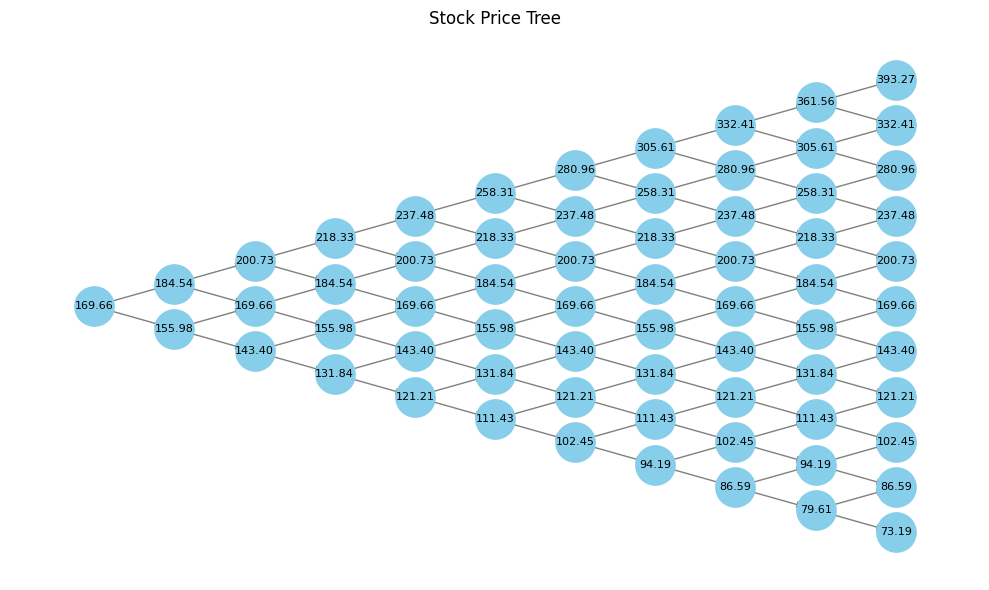

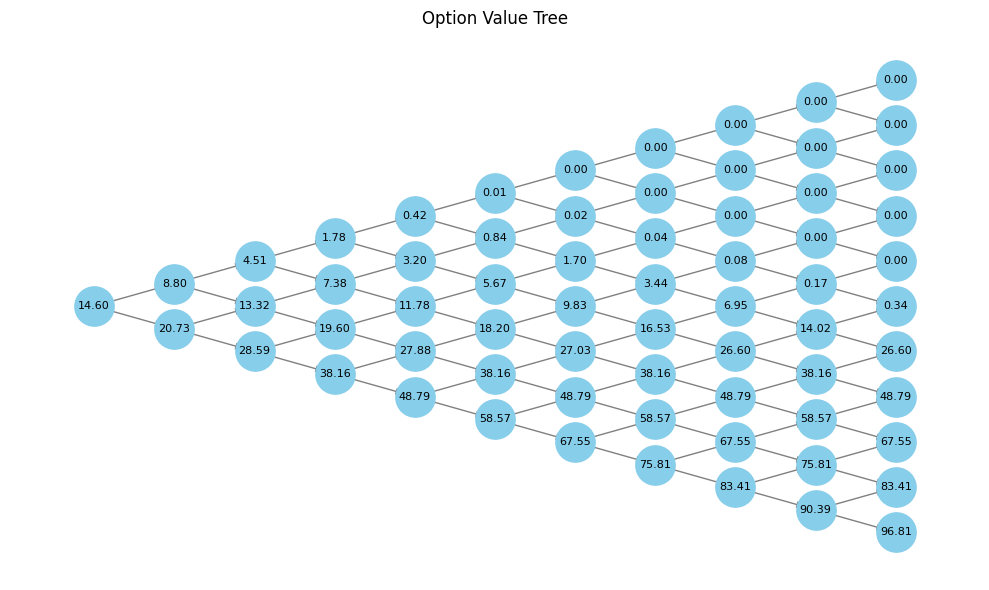

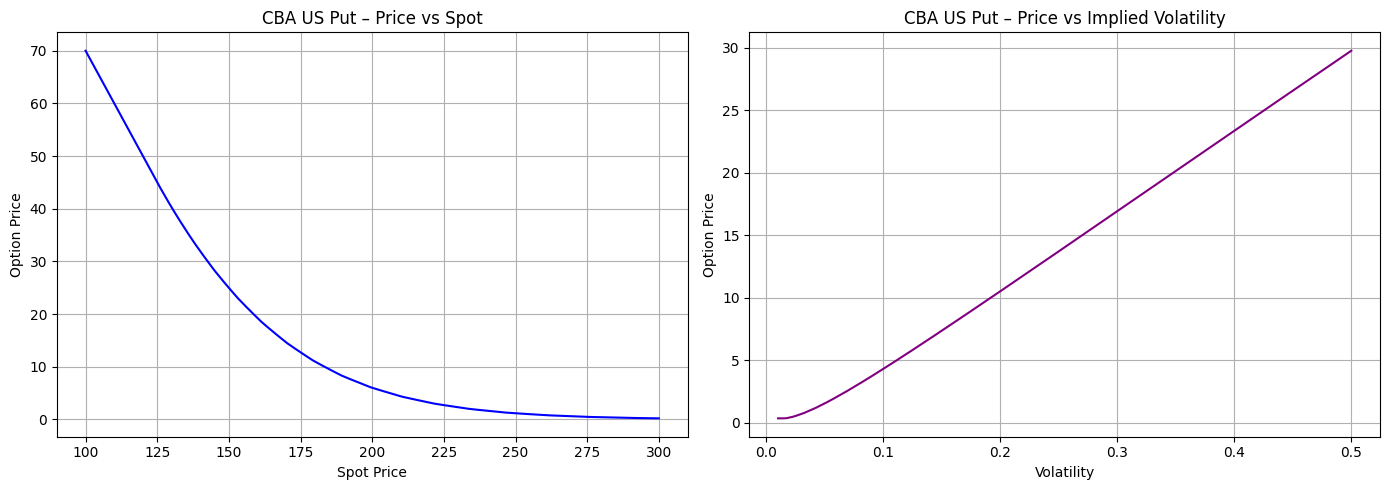

In [13]:
import tree_visualiser
importlib.reload(tree_visualiser)
from tree_visualiser import get_stock_and_option_trees, plot_binomial_tree_networkx
spot = spot_cba
strike = strike_cba
expiry = expiry_cba
rate = rate_cba
vol = vol_cba
steps = 10

stock_tree, option_tree = get_stock_and_option_trees(spot, strike, expiry, rate, vol, steps)

plot_binomial_tree_networkx(stock_tree, title="Stock Price Tree")
plot_binomial_tree_networkx(option_tree, title="Option Value Tree")



plot_spot_vol_sensitivity(option_class=AmericanPutOption, label = "CBA US Put", base_spot=spot_cba, base_vol=vol_cba, spot_range=(100,300,200), vol_range=(0.01,0.5,200), ticker=ticker_cba, strike=strike_cba, expiry=expiry_cba, rate=rate_cba, option_type="put")




### Hedging Parameters

In [14]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho
hc = HedgingCalculator()
greeks_cba = hc.get_all_greeks(cba_option, method="fd")

print("Greeks for CBA Option:")
for greek, value in greeks_cba.items():
    print(f"{greek}: {value}")

Greeks for CBA Option:
delta: -0.5281485226671379
gamma: 7.105427357601002e-11
vega: 63.63658241548391
theta: 6.871852415100371
rho: -64.3791386844228


### Hedging Strategy

### Design and Model Justification

## Trade 3: WES Barrier Call

description of the trade

### Market Data

In [15]:
ticker_wes = "WES.AX"
date = "2025-05-16"

spot_wes = get_close_price(ticker_wes, date) #good
vol_wes = get_volatility(ticker_wes, end_date=date, window=60) #good
strike_wes = 80
barrier_wes = 100

def time_to_expiry(start, end):
    return (end - start).days / 365.0

expiry_wes = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years

print(f"Spot Price: {spot_wes}, Volatility: {vol_wes}, Strike Price: {strike_wes}, Expiry: {expiry_wes} years, Barrier: {barrier_wes}")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Spot Price: 82.55999755859375, Volatility: 0.21930636472137627, Strike Price: 80, Expiry: 2.334246575342466 years, Barrier: 100


### Discount Rate

In [16]:
rate_wes = get_discount_rate(expiry_wes) 
print(f"Rate for WES Option: {rate_wes}")

Rate for WES Option: 0.05592461897265064


### Valuation

In [17]:
# Instantiate and price the option 
dividend_yield_wes = 0.02762
wes_option = UpAndInCallOption(ticker=ticker_wes, spot=spot_wes, strike=strike_wes, expiry=expiry_wes, rate=rate_wes, vol=vol_wes, barrier=barrier_wes, simulations=10000, steps=252, dividend_yield=dividend_yield_wes)
print(f"Option Price: {wes_option.price()}")

Option Price: 13.332223269185214


### Visualisation

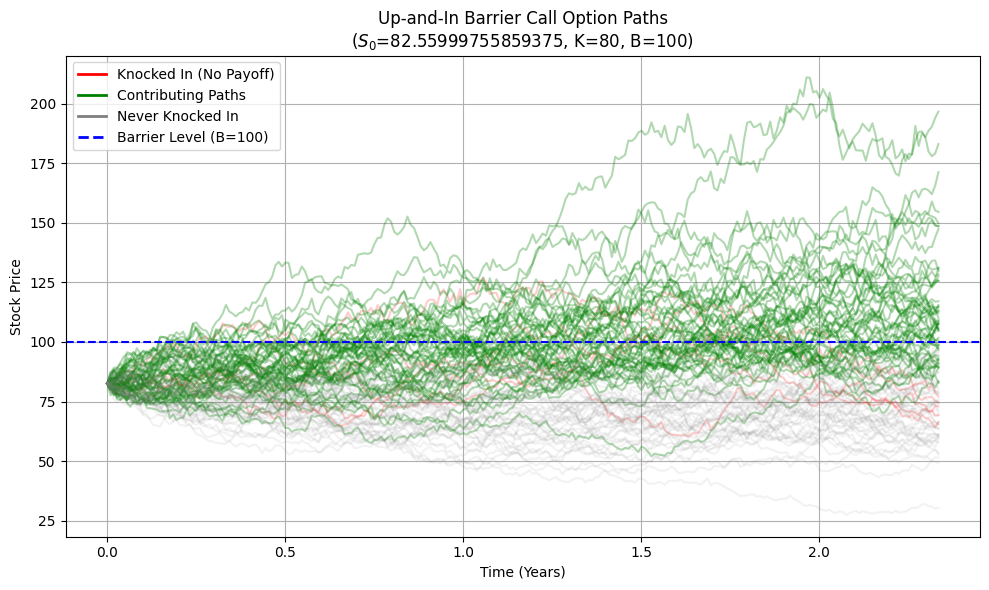

In [18]:
import visualise
importlib.reload(visualise)
from visualise import visualize_up_and_in_barrier_call

visualize_up_and_in_barrier_call(
    S0=spot_wes,
    K=strike_wes,
    T=expiry_wes,
    r=rate_wes,
    sigma=vol_wes,
    B=barrier_wes,
    M=100,
    steps=252
)

## Works but is just very very very slow

### Hedging Parameters

In [19]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho
hc = HedgingCalculator()
greeks_wes = hc.get_all_greeks(wes_option, method="fd")

print("Greeks for WES Option:")
for greek, value in greeks_wes.items():
    print(f"{greek}: {value}")

Greeks for WES Option:
delta: -11.39211418719528
gamma: 864.1466834233036
vega: 51.9694962105147
theta: -19.0411902162149
rho: 244.71273181729813


### Hedging Strategy

### Design and Model Justification

## Trade 4: Basket Call

description of the trade

### Market Data

In [20]:
# Basket Call Option Inputs
tickers_basket = ["BHP.AX", "CSL.AX", "WDS.AX", "MQG.AX"]
date = "2025-05-16"
spot = {ticker: get_close_price(ticker, date) for ticker in tickers_basket}
vol = {ticker: get_volatility(ticker, end_date=date, window=60) for ticker in tickers_basket}
spot_basket = [spot[t] for t in tickers_basket]
vol_basket = [vol[t] for t in tickers_basket]
basket_corr = get_correlation_matrix(tickers_basket, window=60, end_date=date)
weights = [0.10, 0.35, 0.15, 0.40]
strike_basket = 175.0

from datetime import datetime
expiry_basket = time_to_expiry(datetime(2025, 5, 16), datetime(2025, 7, 17))

print("Spot prices:", spot_basket)
print("Volatilities:", vol_basket)
print(f"Strike: {strike_basket}, Expiry: {expiry_basket:.2f} yrs")
print(basket_corr)


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Spot prices: [39.720001220703125, 241.82000732421875, 21.920000076293945, 207.35000610351562]
Volatilities: [0.29673778004012413, 0.2645795058608444, 0.40561362662594136, 0.3774390594028384]
Strike: 175.0, Expiry: 0.17 yrs
Ticker    BHP.AX    CSL.AX    MQG.AX    WDS.AX
Ticker                                        
BHP.AX  1.000000  0.451883  0.444790  0.549149
CSL.AX  0.451883  1.000000  0.450133  0.407607
MQG.AX  0.444790  0.450133  1.000000  0.647139
WDS.AX  0.549149  0.407607  0.647139  1.000000


### Discount Rate

In [21]:
import importlib
import simple_discount_curve
importlib.reload(simple_discount_curve)
from simple_discount_curve import get_discount_rate, get_discount_factor

rate_basket = get_discount_rate(expiry_basket)
print(f"Discount rate: {rate_basket:.4%}")

Discount rate: 8.8975%


### Valuation

In [ ]:
# Instantiate and price the option 
dividend_yield_basket = 0.044268  #weighted average of asset div yields taken from Bloomberg
basket_option = BasketCallOption(tickers=tickers_basket, spot_prices=spot_basket, weights=weights, strike=strike_basket, expiry=expiry_basket, rate=rate_basket, vol=vol_basket, corr_matrix=basket_corr, dividend_yield=dividend_yield_basket)
print(f"Basket Option Price: {basket_option.price()}")

Basket Option Price: 8.285858590261356


### Visualisation

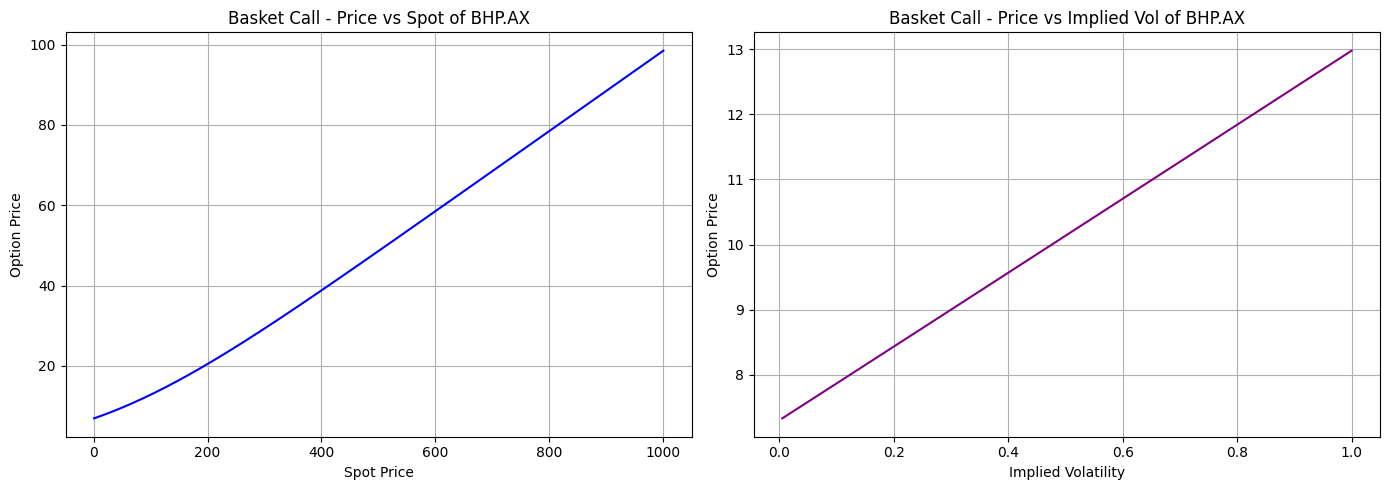

In [23]:
plot_spot_vol_sensitivity_basket_bs(
    label="Basket Call",
    base_spots=spot_basket,
    base_vols=vol_basket,
    weights=weights,
    corr_matrix=basket_corr,
    strike=strike_basket,
    expiry=expiry_basket,
    rate=rate_basket,
    ticker="Basket",
    tickers=tickers_basket,
    component_index=0, # 0 = BHP, 1 = CSL, 2 = WDS, 3 = MQG
    spot_range=(1, 1000, 200),
    vol_range=(0.005, 1, 40),
    option_class=BasketCallOption
)


### Hedging Parameters

In [24]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho
hc = HedgingCalculator()
greeks_basket = hc.get_all_greeks(basket_option, method="fd")

print("Greeks for Basket Option:")
for greek, value in greeks_basket.items():
    print(f"{greek}: {value}")

Greeks for Basket Option:
delta: [np.float64(0.055867733989600765), np.float64(0.19553706878525645), np.float64(0.08380160097516409), np.float64(0.22347093568839682)]
gamma: [np.float64(0.0002014175493059156), np.float64(0.002467359934144042), np.float64(0.00045318870434130076), np.float64(0.003222674536118575)]
vega: [np.float64(1.8980677616006858), np.float64(7.135234651769906), np.float64(3.3481055991487096), np.float64(10.223412799759757)]
theta: 28.674242124444845
rho: 15.11696222195269


### Hedging Strategy

### Design and Model Justification (might remove)

## Portfolio Valuation and Hedging Summary (might remove)

In [28]:
# Collect all option prices and Greek exposures into summary DataFrame
# Sum portfolio value and Greek sensitivities

## Design and Model Justification (might remove)

- Why Black-Scholes, Binomial Tree, and Monte Carlo were chosen
- Why finite difference for Greeks
- Why the bump sizes used
- Accuracy vs flexibility trade-offs

## Conclusion

- Modular, OOP-driven pricing system
- Accurate pricing and hedging of diverse OTC trades
- Integration of real market data and theory